In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
from utils.ml_utils import *
from typing import List, Dict
from pyod.models.ecod import ECOD
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest

In [2]:
file_path = "Data/metrics_collector.tsv"

column_names = [
    'account_id', 'name', 'point', 'call_count', 'total_call_time', 
    'total_exclusive_time', 'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 'language', 'app_name', 
    'app_id', 'scope', 'host', 'display_host', 'pid', 
    'agent_version', 'labels'
]

data = pd.read_csv(file_path, sep='\t', header=None)
data.columns = column_names
metrics_table = make_table(data)
metrics_table

/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_55375/471163818.py:11: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, sep='\t', header=None)
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["point"] = pd.to_datetime(filtered_data["point"])
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,time,time_numeric,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,28553732.0,0.007722,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,28553733.0,0.008363,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,28553734.0,0.008709,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,28553735.0,0.008286,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,28553736.0,0.010874,3915.5,0.999489,0.000000
...,...,...,...,...,...,...
43267,2024-05-16 00:54:00,28597014.0,0.009245,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,28597015.0,0.010571,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,28597016.0,0.011785,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,28597017.0,0.010940,2373.5,0.997999,0.000211


In [3]:
start_date = pd.to_datetime("2024-04-15 23:32:00")
end_date = pd.to_datetime("2024-05-16 00:58:00")
columns_name = ["web_response", "throughput"]
result = ml(metrics_table, start_date, end_date, columns_name)

In [4]:
df = result["web_response"]
df[df["labels"]==1]

,labels,probability,time,value
934,1,1.000000,2024-04-16 15:06:00,0.271858
935,1,0.982124,2024-04-16 15:07:00,0.155026
1041,1,0.997526,2024-04-16 16:53:00,0.215703
1042,1,0.997526,2024-04-16 16:54:00,0.214911
1169,1,0.996147,2024-04-16 19:01:00,0.247639
1170,1,0.996147,2024-04-16 19:02:00,0.237886
5271,1,0.970123,2024-04-19 15:35:00,0.295971
5272,1,0.957511,2024-04-19 15:36:00,0.193837
5509,1,0.967520,2024-04-19 19:33:00,0.203959
5510,1,0.967520,2024-04-19 19:34:00,0.223654


In [5]:
df = result["web_response"]
df[df["labels"]==0]

,labels,probability,time,value
0,0,0.367965,2024-04-15 23:32:00,0.007722
1,0,0.342935,2024-04-15 23:33:00,0.008363
2,0,0.354129,2024-04-15 23:34:00,0.008709
3,0,0.344670,2024-04-15 23:35:00,0.008286
4,0,0.357770,2024-04-15 23:36:00,0.010874
...,...,...,...,...
43267,0,0.308851,2024-05-16 00:54:00,0.009245
43268,0,0.309743,2024-05-16 00:55:00,0.010571
43269,0,0.316068,2024-05-16 00:56:00,0.011785
43270,0,0.317295,2024-05-16 00:57:00,0.010940


(array([1647., 8159., 8194., 5799., 4682., 3782., 2562., 1928., 1280.,
        1061.,  916.,  660.,  425.,  377.,  371.,  264.,  208.,  173.,
         125.,  108.,   88.,   52.,   57.,   94.,   81.,   32.,   41.,
          45.,   45.,   16.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

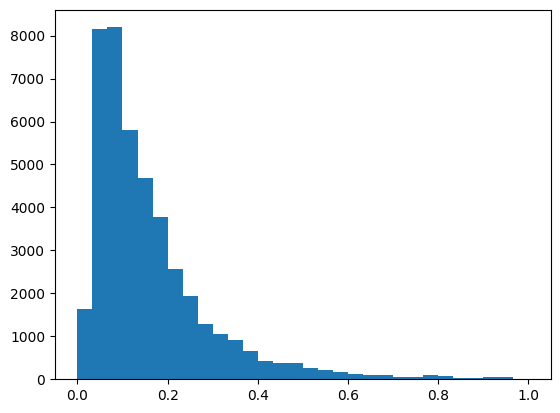

In [6]:
plt.hist(df["probability"], bins=30)

In [7]:
a = ["web_response", "throughput"]
print(a)
a.extend(["time"])
print(a)

['web_response', 'throughput']
['web_response', 'throughput', 'time']


In [8]:
columns_names.extend(['time', 'time_numeric'])
filtered_df = data[(metrics_table['time'] >= start_date) & (metrics_table['time'] <= end_date)][column_names]

NameError: name 'columns_names' is not defined

In [ ]:
column_names

['account_id',
 'name',
 'point',
 'call_count',
 'total_call_time',
 'total_exclusive_time',
 'min_call_time',
 'max_call_time',
 'sum_of_squares',
 'instances',
 'language',
 'app_name',
 'app_id',
 'scope',
 'host',
 'display_host',
 'pid',
 'agent_version',
 'labels',
 'time',
 'time_numeric',
 'time',
 'time_numeric',
 'time',
 'time_numeric']

In [ ]:
metrics_table.dtypes

time            datetime64[ns]
time_numeric           float64
web_response           float64
throughput             float64
apdex                  float64
error                  float64
dtype: object

In [ ]:
metrics_table = make_table(data)
metrics_table

/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["point"] = pd.to_datetime(filtered_data["point"])
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = filtered_data['point']
/Users/alexander/Учёба/ХАКАТОНЫ/RedLab/redlab_hack/utils/utils.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,time,time_numeric,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,28553732.0,0.007722,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,28553733.0,0.008363,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,28553734.0,0.008709,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,28553735.0,0.008286,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,28553736.0,0.010874,3915.5,0.999489,0.000000
...,...,...,...,...,...,...
43267,2024-05-16 00:54:00,28597014.0,0.009245,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,28597015.0,0.010571,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,28597016.0,0.011785,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,28597017.0,0.010940,2373.5,0.997999,0.000211


In [ ]:
metrics_table

,time,time_numeric,web_response,throughput,apdex,error
0,2024-04-15 23:32:00,28553732.0,0.007722,3898.0,0.999679,0.000128
1,2024-04-15 23:33:00,28553733.0,0.008363,3917.5,0.999745,0.000128
2,2024-04-15 23:34:00,28553734.0,0.008709,3993.0,0.999687,0.000000
3,2024-04-15 23:35:00,28553735.0,0.008286,3991.5,0.999812,0.000000
4,2024-04-15 23:36:00,28553736.0,0.010874,3915.5,0.999489,0.000000
...,...,...,...,...,...,...
43267,2024-05-16 00:54:00,28597014.0,0.009245,2560.0,0.998828,0.000000
43268,2024-05-16 00:55:00,28597015.0,0.010571,2491.0,0.998495,0.000000
43269,2024-05-16 00:56:00,28597016.0,0.011785,2429.0,0.997736,0.000206
43270,2024-05-16 00:57:00,28597017.0,0.010940,2373.5,0.997999,0.000211


In [ ]:
metrics_table["web_response"].value_counts()

web_response
0.104918    14
0.133031     2
0.007722     1
0.007592     1
0.006372     1
            ..
0.006768     1
0.006785     1
0.006759     1
0.006389     1
0.007973     1
Name: count, Length: 43258, dtype: int64

In [ ]:
def plot_anomalies(data, anomaly_mask, value_col):
    
    metrics_table_copy = data.copy()
    metrics_table_copy['anomaly'] = anomaly_mask
    
    plt.figure(figsize=(40, 20))
    plt.plot(metrics_table_copy["time"], metrics_table_copy[value_col], color='blue', label=value_col)
    plt.scatter(metrics_table_copy[metrics_table_copy['anomaly'] == 1]["time"], 
                metrics_table_copy[metrics_table_copy['anomaly'] == 1][value_col], 
                color='red', label='Anomaly', zorder=5)
    plt.title(f'{value_col} with Anomalies')
    plt.xlabel('Time')
    plt.ylabel(value_col)
    plt.legend()
    plt.grid(True)
    plt.show()


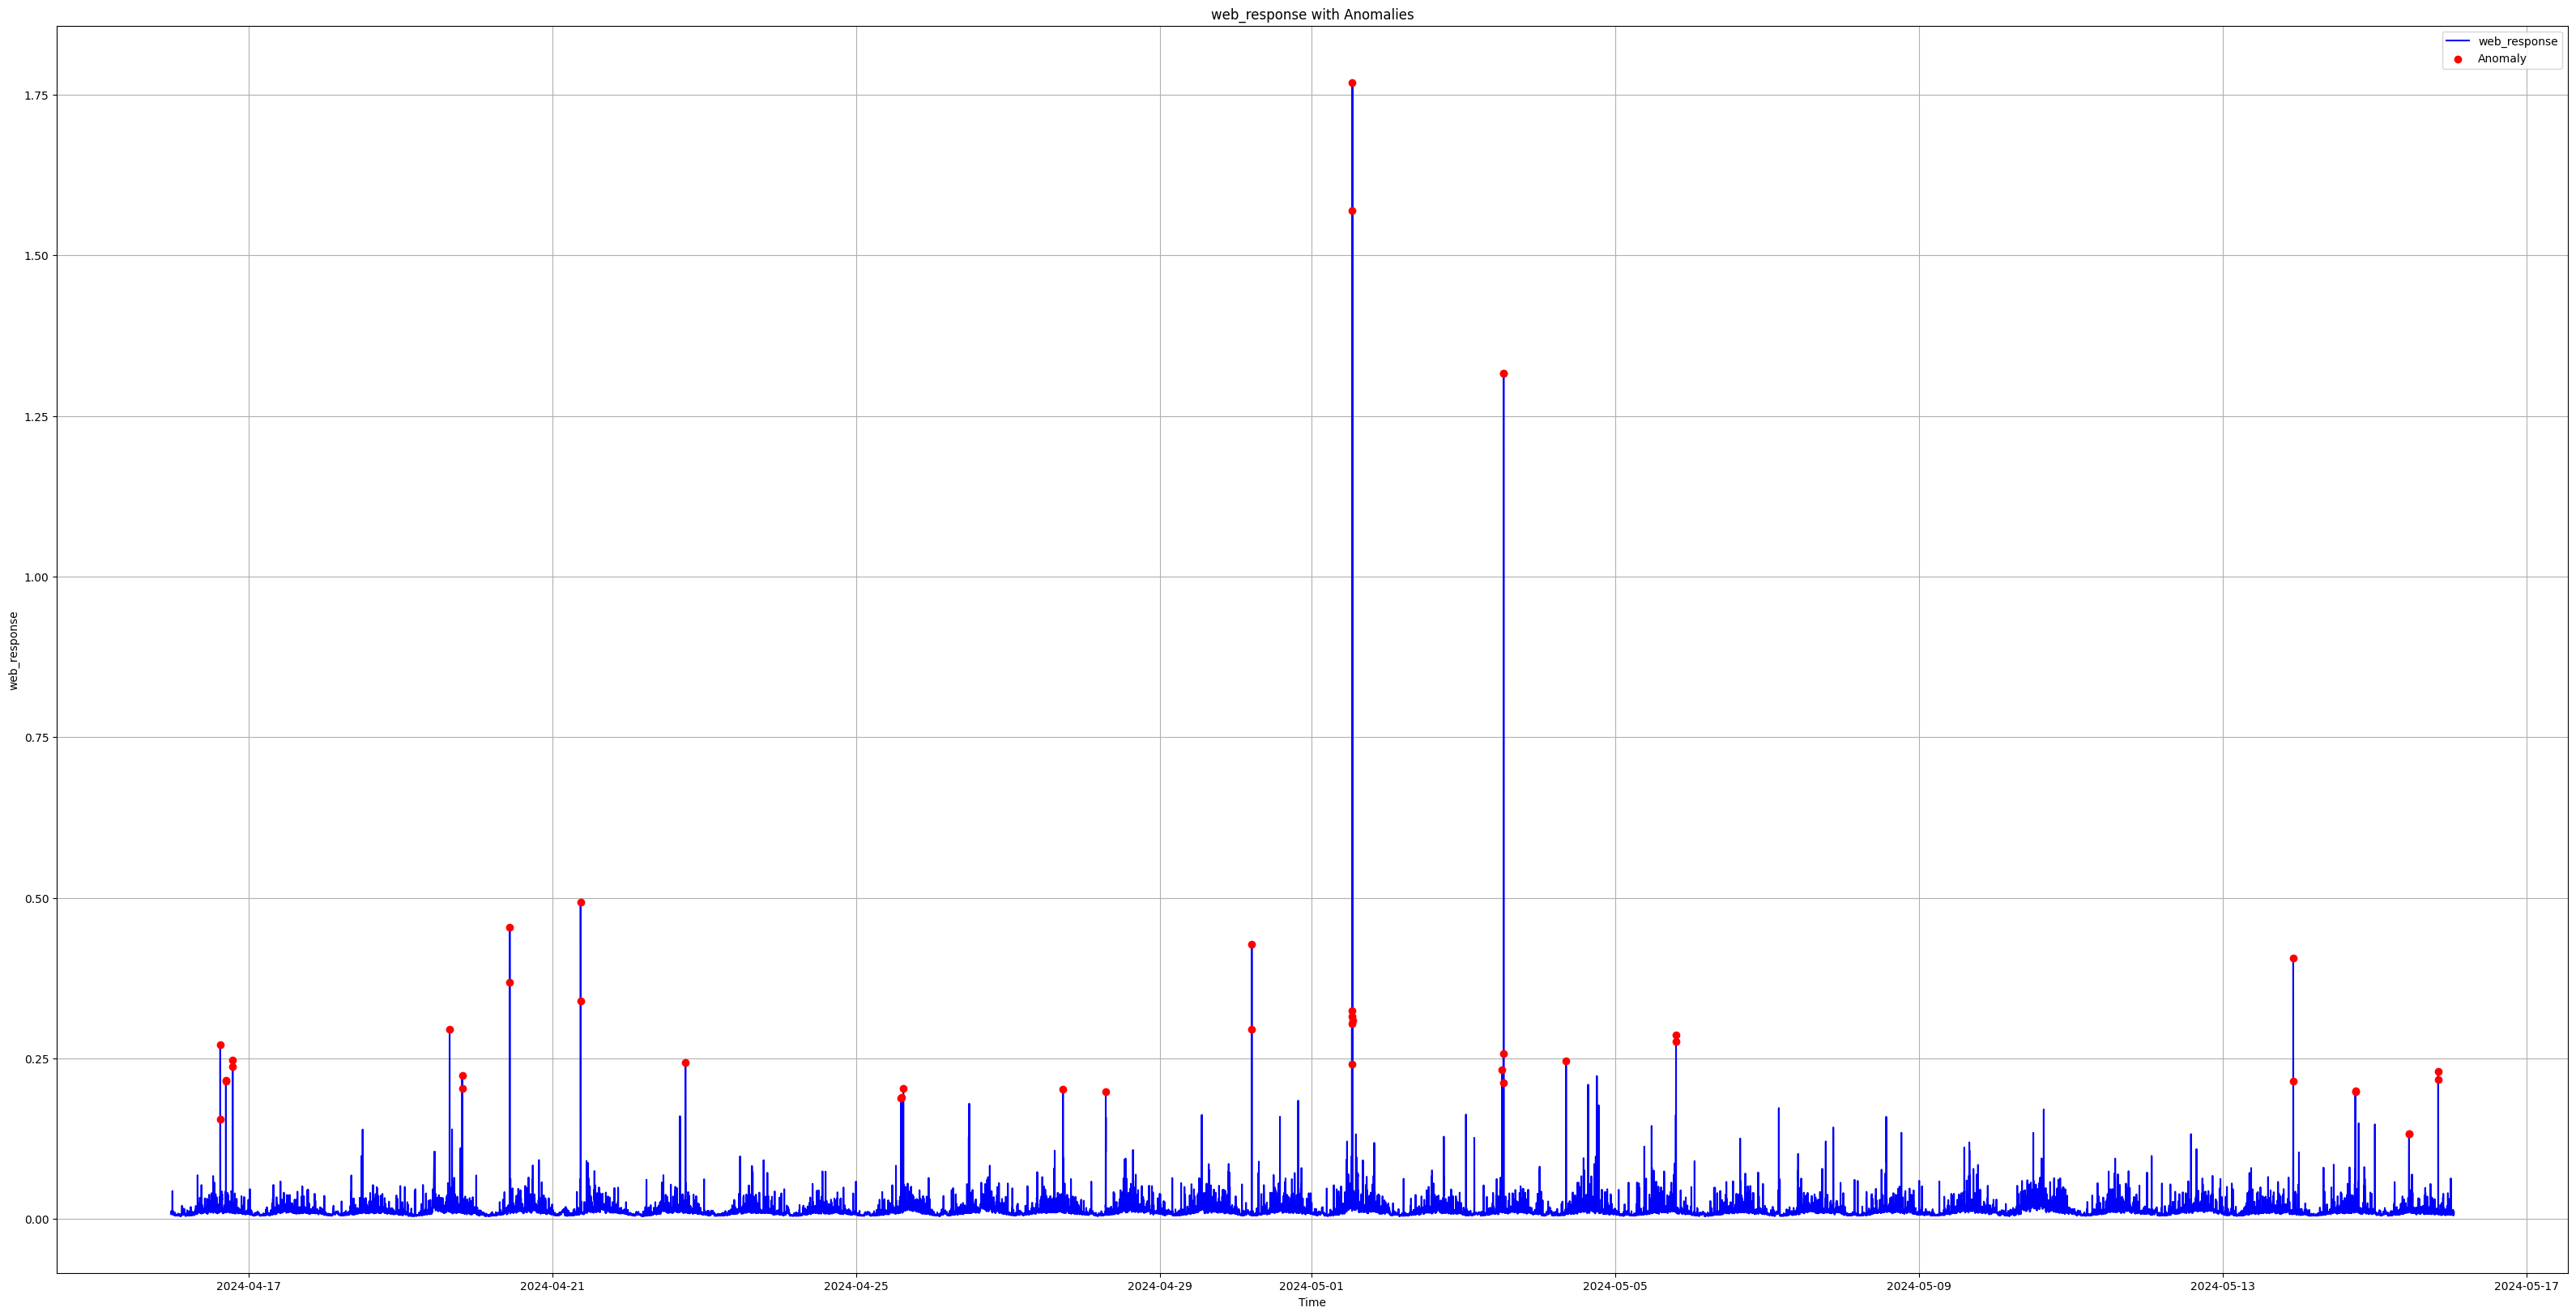

{'variance_diff': -68.90953043517894,
 'fraction_anomaly': 0.0010168238121649102}

In [ ]:
feature = "web_response"
data = metrics_table[['time_numeric', feature]].values

# Обучение модели IForest
clf =  IForest(
    #n_neighbors=2,
    contamination=0.001
    #n_jobs=-1
)

clf.fit(data)
labels = clf.labels_  # Метки аномалий (0: нормальный, 1: аномалия)
scores = clf.decision_scores_  # Оценки аномалий

plot_anomalies(metrics_table, labels, feature)
metrics(metrics_table, labels, feature)

In [ ]:
type(data)

numpy.ndarray